In [25]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=3,doc_content_chars_max=600)
wikipedia_api_wrapper = WikipediaAPIWrapper(top_k_results=3,doc_content_chars_max=600)

arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)
wikipedia = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)



In [26]:
arxiv.invoke("What is the latest research on quantum computing?")

'Published: 2023-05-23\nTitle: Fast and energy-efficient non-volatile III-V-on-silicon photonic phase shifter based on memristors\nAuthors: Zhuoran Fang, Bassem Tossoun, Antoine Descos, Di Liang, Xue Huang, Geza Kurczveil, Arka Majumdar, Raymond G. Beausoleil\nSummary: Silicon photonics has evolved from lab research to commercial products in the\npast decade as it plays an increasingly crucial role in data communication for\nnext-generation data centers and high performance computing1. Recently,\nprogrammable silicon photonics has also found new applications in quantum2 and\nclassical 3 information pr'

In [27]:
wikipedia.invoke("What is frontend computing?")

'Page: LLVM\nSummary: LLVM, also called LLVM Core, is a target-independent optimizer and code generator. It can be used to develop a frontend for any programming language and a backend for any instruction set architecture. LLVM is designed around a language-independent intermediate representation (IR) that serves as a portable, high-level assembly language that can be optimized with a variety of transformations over multiple passes. The name LLVM originally stood for Low Level Virtual Machine. However, the project has since expanded, and the name is no longer an acronym but an orphan initialism.'

In [ ]:
# import os
# from  dotenv import load_dotenv
# load_dotenv()

# os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [ ]:
# import os
# from dotenv import load_dotenv

# load_dotenv()

# from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_tavily import TavilySearch

# tavily = TavilySearch(api_key=os.getenv("TAVILY_API_KEY"))
# tavily.invoke("What is quantum computing?")

{'query': 'What is quantum computing?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is quantum computing? - IBM',
   'url': 'https://www.ibm.com/think/topics/quantum-computing',
   'content': 'What Is Quantum Computing? What is quantum computing? What is quantum computing? The primary difference between classical and quantum computers is that quantum computers use qubits instead of bits. While quantum computing does use binary code, qubits process information differently from classical computers. Because qubits can hold a superposition and exhibit interference, a quantum computer that uses qubits approaches problems in ways different from classical computers. IBM Quantum Computing  ### What is quantum computing? Quantum computers, like classical computers, are problem-solving machines. ### The difference between quantum and classical computing #### Quantum computing Unlike classical computers that must compute every step of a complicated c

In [ ]:
tools = [arxiv, wikipedia,tavily]

from langchain_groq import ChatGroq

llm = ChatGroq(model="Gemma2-9b-It")

llm_with_tools = llm.bind_tools(tools)


In [12]:
## deifining state schema

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    


def tool_fucntion(State:State) -> dict:
    """    Function to invoke the LLM with tools and return the messages.
    Args:
        State (State): The state containing the messages.
    Returns:
        dict: A dictionary containing the messages after invoking the LLM with tools.

    """   
     # Invoke the LLM with tools and return the messages
    return {'messages':llm_with_tools.invoke(State['messages'])}

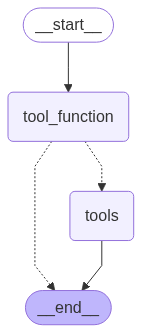

In [30]:
# defining the graph

from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image
from langgraph.prebuilt import ToolNode,tools_condition


graph = StateGraph(State)

graph.add_node("tool_function",tool_fucntion)
graph.add_node('tools',ToolNode(tools))

graph.add_edge(START,"tool_function")
graph.add_conditional_edges('tool_function',
#is the latest message (result of the tool invocation) triigers a tool call then tools_consotion will route to tools,
#if not it will route to END
tools_condition)
graph.add_edge('tools',END)



graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [31]:
from  langchain_core.messages import HumanMessage, ToolMessage

messages = graph_builder.invoke({"messages":HumanMessage("tell me about recent developments in AI field?")})


for message in messages['messages']:
    message.pretty_print()  # Print the message content

================================ Human Message =================================

tell me about recent developments in AI field?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (aee7qfmgc)
 Call ID: aee7qfmgc
  Args:
    query: recent developments in AI field
    search_depth: advanced
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent developments in AI field", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Top AI Trends 2025: Key Developments to Watch - Appinventiv", "url": "https://appinventiv.com/blog/ai-trends/", "content": "One of the most notable new developments in the AI field is the use of autonomous systems to make decisions for users. These AI agents are made to take on jobs proactively, enhancing output and decision-making across a range of sectors, including banking and healthcare. Agentic